In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

%matplotlib inline

### 1. С сайта [cbioportal.org](http://www.cbioportal.org/) получить данные TCGA-SKCM по когорте больных меланомой.

In [14]:
data_pat = pd.read_csv("./skcm_tcga/data_bcr_clinical_data_patient.txt", sep='\t', comment='#')
data_pat.shape

(470, 61)

In [148]:
data_sam = pd.read_csv("./skcm_tcga/data_bcr_clinical_data_sample.txt", sep='\t', comment='#')
data_sam.shape

(480, 25)

### 2. Гомогенная ли выборка пациентов? Как лучше убрать выбросы?
Проанализируем данные известных признаков и попробем найти необычные значения.

Посмотрим на соотношения пациентов Overall Survival Status и Disease Free Status. Среди живых есть как вылечившиеся, так и больные пациенты. При этом среди мертвых только больные или без информации. Мы предполагаем, что в наших данных смерть пациентов наступает исключительно по причине онкологии, поэтому у всех умерших пациентов заполняем состояние опухоли как прогрессировавшее.

In [15]:
print(data_pat.groupby(['OS_STATUS', 'DFS_STATUS']).size())
data_pat.loc[data_pat.OS_STATUS == 'DECEASED', 'DFS_STATUS'] = 'Recurred/Progressed'

OS_STATUS  DFS_STATUS         
DECEASED   Recurred/Progressed    163
           [Not Available]         60
LIVING     DiseaseFree            150
           Recurred/Progressed     97
dtype: int64


Один из самых простых признаков - возраст пациента. Он варьируется от 15 до 90 лет. Предположим, что очень юные пациенты являются скорее исключением, чем достоверным источником данных о раке, а самые пожилые чаще всего умирают от других причин и также могут вносить шум в данные.

(array([  6.,  15.,  26.,  42.,  73.,  79.,  73.,  70.,  57.,  21.]),
 array([ 15. ,  22.5,  30. ,  37.5,  45. ,  52.5,  60. ,  67.5,  75. ,
         82.5,  90. ]),
 <a list of 10 Patch objects>)

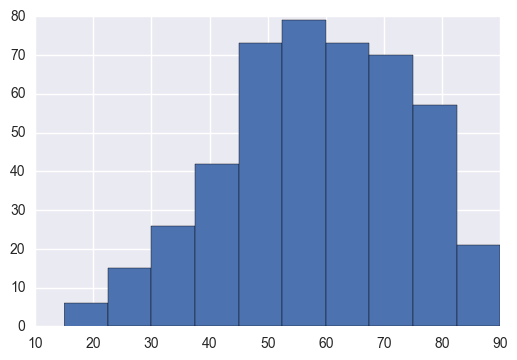

In [4]:
plt.hist(data_pat.AGE[data_pat.AGE != '[Not Available]'].astype('int32'))

Будем предполагать, что признак у пациентов распределен близко к нормальному, что позволяет использовать правило двух сигм для отбора приблизительно 95% пациентов с допустимым отклонением признака от нормы. 

In [16]:
def delete_outliers(data, column, m=2.):
    col_values = column.copy()
    col_values[col_values != '[Not Available]'] = col_values[col_values != '[Not Available]'].astype('float')
    col_values[col_values == '[Not Available]'] = None
    e, std = np.mean(col_values), np.std(col_values)
    # we want also to keep unknown values of a feature
    return data[np.logical_or(np.array(col_values.between(e-m*std, e+m*std)), np.array(column.isnull()))]

В выборке теперь отсутствуют пациенты младше 27 и старше 87, количество пациентов теперь достаточное для анализа каждой возрастной группы. Пациенты с неизвестным возрастом также сохранены в выборке.

In [17]:
age = data_pat.AGE[data_pat.AGE != '[Not Available]']
print('Before deteting age outliers were patients from ', min(age), 'to', max(age))
data_pat = delete_outliers(data_pat, data_pat.AGE)
print('After deteting age outliers there are patients from ', min(data_pat.AGE), 'to', max(data_pat.AGE))
print(data_pat.shape)

Before deteting age outliers were patients from  15 to 90
After deteting age outliers there are patients from  27 to 87
(441, 61)


Следующим критерием рассмотрим излишний/недостаточний вес пациента, но чисто колонка ВЕС для этого плохо подходит. Воспользуемся индексом массы тела (ИМТ = вес/рост^2). Это позволит отсеить пациентов с аномальным ожирением или дистрофией.

In [18]:
w = data_pat.WEIGHT.copy()
w.loc[w != '[Not Available]',] = w[w != '[Not Available]'].astype('float')
w.loc[w == '[Not Available]',] = None

h = data_pat.HEIGHT.copy()
h.loc[h != '[Not Available]',] = h[h != '[Not Available]'].astype('float')
h.loc[h == '[Not Available]',] = None
h = h/100 # convert height to meters

BMI = w/h**2 # body mass index
data_pat['BMI'] = BMI

(array([ 18.,  58.,  72.,  39.,  22.,  11.,   3.,   3.,   2.,   1.]),
 array([ 17. ,  20.8,  24.6,  28.4,  32.2,  36. ,  39.8,  43.6,  47.4,
         51.2,  55. ]),
 <a list of 10 Patch objects>)

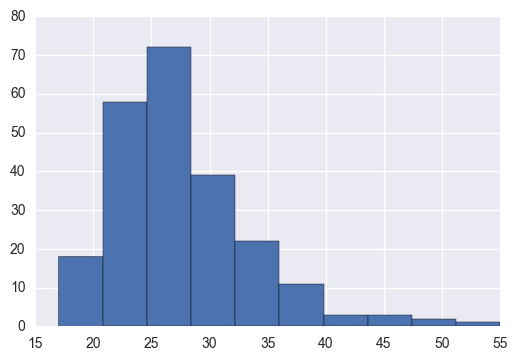

In [8]:
plt.hist(data_pat.BMI[data_pat.BMI.notnull()].astype('int32'))

После все еще есть люди с дефицитом веса и ожирением, но экстремальные значения этих показателей теперь существенно снизились.

In [19]:
print('Before deteting BMI outliers were patients from ', int(min(data_pat.BMI)), 'to', int(max(data_pat.BMI)))
data_pat = delete_outliers(data_pat, data_pat.BMI)
print('After deteting BMI outliers there are patients from ', int(min(data_pat.BMI)), 'to', int(max(data_pat.BMI)))
print(data_pat.shape)

Before deteting BMI outliers were patients from  17 to 55
After deteting BMI outliers there are patients from  17 to 39
(432, 62)


Теперь рассмотрим значения динамики опухоли. Большинство людей живет не более 50 месяцев с момента постановки диагноза. Попробуем для каждого пациента вычесть из данных Overall Survival (Months) значение Disease Free (Months), это позволит оценить продолжительность болезни для всех известных пациентов. Это позволит отбросить пациентов с необычно длительной болезнью.

Поскольку распределение скорее похоже экспоненциальное, в качестве фильтра будем использовать квантили, чтобы отобрать 95% наиболее стандартных пациентов. 

In [20]:
os = data_pat.OS_MONTHS.copy()
os.loc[os != '[Not Available]',] = os[os != '[Not Available]'].astype('float')
os.loc[os == '[Not Available]',] = None

dfs = data_pat.DFS_MONTHS.copy()
dfs.loc[dfs != '[Not Available]',] = dfs[dfs != '[Not Available]'].astype('float')
dfs.loc[dfs == '[Not Available]',] = None

ds = os - dfs # Disease Survival (months)
data_pat['DS'] = ds

(array([ 309.,   38.,   10.,    6.,    2.,    3.,    1.,    3.,    1.,    1.]),
 array([  -3. ,   16.6,   36.2,   55.8,   75.4,   95. ,  114.6,  134.2,
         153.8,  173.4,  193. ]),
 <a list of 10 Patch objects>)

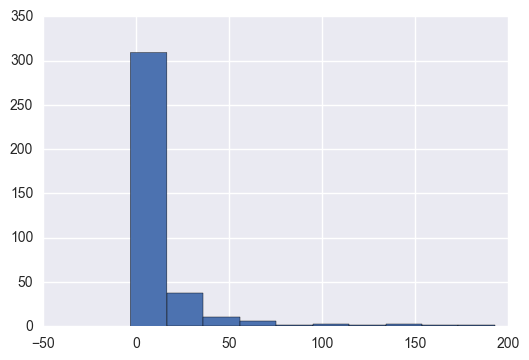

In [12]:
plt.hist(ds[ds.notnull()].astype('int32'))

95% пациентов имели продолжительность болезни менее 53 месяцев (около 4,5 лет). 

In [21]:
print(np.percentile(ds[ds.notnull()], 95)) # Q0.95 value
data_pat = data_pat.loc[data_pat.DS < np.percentile(ds[ds.notnull()], 90)]
print(data_pat.shape)

52.657999999999944
(336, 63)


In [22]:
data_pat.to_csv('./skcm_tcga/data_bcr_clinical_data_patient_filtered.txt', sep='\t', index=False)

# ToDo add sample information

In [33]:
data_sam.columns

Index(['PATIENT_ID', 'SAMPLE_ID', 'OTHER_SAMPLE_ID', 'SPECIMEN_CURRENT_WEIGHT',
       'DAYS_TO_COLLECTION', 'DAYS_TO_SPECIMEN_COLLECTION',
       'SPECIMEN_FREEZING_METHOD', 'SAMPLE_INITIAL_WEIGHT',
       'SPECIMEN_SECOND_LONGEST_DIMENSION', 'IS_FFPE', 'LONGEST_DIMENSION',
       'METHOD_OF_SAMPLE_PROCUREMENT', 'OCT_EMBEDDED',
       'OTHER_METHOD_OF_SAMPLE_PROCUREMENT', 'PATHOLOGY_REPORT_FILE_NAME',
       'PATHOLOGY_REPORT_UUID', 'SAMPLE_TYPE', 'SAMPLE_TYPE_ID',
       'SHORTEST_DIMENSION', 'TIME_BETWEEN_CLAMPING_AND_FREEZING',
       'TIME_BETWEEN_EXCISION_AND_FREEZING', 'VIAL_NUMBER', 'ONCOTREE_CODE',
       'CANCER_TYPE', 'CANCER_TYPE_DETAILED'],
      dtype='object')

### 3. Посчитать для каждого образца количество клеток, инфильтрирующих опухоль, с помощью пакета [immunedeconv](https://github.com/icbi-lab/immunedeconv).
Для подсчета был использован скрипт на R, результаты работы которого сохранены в табличном виде. [Шпаргалка](https://icbi-lab.github.io/immunedeconv/articles/immunedeconv.html) для удобства. Данные рекомендуется передавать в виде TPM и без лог преобразования.

Данные экспрессии были нормированы с помощью CPM (<code>apply(expr_data, 2, function(x) x*10^6/sum(x))</code>), поскольку нет информации о длинах генов.

In [35]:
quantiseq = pd.read_csv('./quantiseq.txt', sep='\t', index_col=0)
quantiseq = quantiseq.T
print(quantiseq.shape)
quantiseq.head()

(472, 11)


cell_type,B cell,Macrophage M1,Macrophage M2,Monocyte,Neutrophil,NK cell,T cell CD4+ (non-regulatory),T cell CD8+,T cell regulatory (Tregs),Myeloid dendritic cell,uncharacterized cell
TCGA.3N.A9WB.06,0.019010,0.025357,0.000000,0.132628,0.034339,0.027568,0.033914,0.000000,0.032508,0.0,0.694675
TCGA.3N.A9WC.06,0.018577,0.077029,0.022916,0.000000,0.596110,0.011411,0.000000,0.162333,0.015568,0.0,0.096056
TCGA.3N.A9WD.06,0.040618,0.048196,0.031013,0.075932,0.074128,0.026484,0.000000,0.043388,0.097349,0.0,0.562892
TCGA.BF.A1PU.01,0.005079,0.023847,0.000000,0.476890,0.000000,0.111910,0.000000,0.000000,0.035172,0.0,0.347103
TCGA.BF.A1PV.01,0.009409,0.000000,0.000000,0.194886,0.484746,0.079115,0.050163,0.000000,0.029180,0.0,0.152501


Каждую полученную таблицу требуется отфильтровать, оставив только отобранные в пункте 2 образцы. Как видно ниже, ID немного отличаются по формату в данных, индексы были приведены сразу к формату ID пациента.

In [36]:
for i,j in zip(data_pat.PATIENT_ID[:5], quantiseq.index[:5]):
    print(i,'~', j)
    
quantiseq = quantiseq.set_index(pd.Series(quantiseq.index).apply(lambda x: '-'.join(x.split('.')[:-1])))
quantiseq = quantiseq.loc[data_pat.PATIENT_ID]
print(quantiseq.shape)

TCGA-3N-A9WB ~ TCGA.3N.A9WB.06
TCGA-3N-A9WC ~ TCGA.3N.A9WC.06
TCGA-3N-A9WD ~ TCGA.3N.A9WD.06
TCGA-BF-A1PU ~ TCGA.BF.A1PU.01
TCGA-BF-A1PV ~ TCGA.BF.A1PV.01
(339, 11)


In [37]:
timer = pd.read_csv('./timer.txt', sep='\t', index_col=0)
timer = timer.T
print(timer.shape)
timer.head()

(472, 6)


cell_type,B cell,T cell CD4+,T cell CD8+,Neutrophil,Macrophage,Myeloid dendritic cell
TCGA.3N.A9WB.06,0.063388,0.037520,0.063192,0.047289,0.0,0.248637
TCGA.3N.A9WC.06,0.047614,0.332219,0.154635,0.265385,0.0,0.596707
TCGA.3N.A9WD.06,0.130618,0.129352,0.108501,0.095524,0.0,0.395941
TCGA.BF.A1PU.01,0.078863,0.000000,0.146578,0.054510,0.0,0.309826
TCGA.BF.A1PV.01,0.052074,0.000000,0.135438,0.051900,0.0,0.287516


In [38]:
timer = timer.set_index(pd.Series(timer.index).apply(lambda x: '-'.join(x.split('.')[:-1])))
timer = timer.loc[data_pat.PATIENT_ID]
print(timer.shape)

(339, 6)


С библиотекой CIBERSORT возникли затруднения, поскольку для ее использования требуется зарегистрироваться на их [сайте](https://cibersort.stanford.edu/), после чего требуется подождать проверки данных от администратора. Мне в итоге так и не пришло одтверждение регистрации (регистрация 16.04.20, по состоянию на 17.04.20 подтверждение не пришло).

In [39]:
# cibersort = pd.read_csv('./cibersort.txt', sep='\t', index_col=0)
# cibersort = cibersort.T
# print(cibersort.shape)
# cibersort.head()

# cibersort = cibersort.set_index(pd.Series(cibersort.index).apply(lambda x: '-'.join(x.split('.')[:-1])))
# cibersort = cibersort.loc[data_pat.PATIENT_ID]
# print(cibersort.shape)

In [40]:
mcp_counter = pd.read_csv('./mcp_counter.txt', sep='\t', index_col=0)
mcp_counter = mcp_counter.T
print(mcp_counter.shape)
mcp_counter.head()

(472, 10)


cell_type,T cell,cytotoxicity score,NK cell,B cell,Monocyte,Macrophage/Monocyte,Myeloid dendritic cell,Neutrophil,Endothelial cell,Cancer associated fibroblast
TCGA.3N.A9WB.06,1.746327,0.562497,0.008380,0.107735,2.271880,2.271880,0.832696,7.115980,7.034443,311.113502
TCGA.3N.A9WC.06,12.841111,22.866774,0.785802,4.920415,46.358063,46.358063,23.776924,8.756505,14.258894,203.380106
TCGA.3N.A9WD.06,6.127954,5.066643,0.207581,23.791589,12.693255,12.693255,3.983298,7.207050,14.897533,189.685481
TCGA.BF.A1PU.01,0.925787,3.366307,0.012325,0.158467,2.390565,2.390565,0.300426,15.983585,19.631497,348.835091
TCGA.BF.A1PV.01,21.264783,4.167785,0.010335,0.248493,6.240195,6.240195,0.826669,17.984004,4.821541,236.306499


In [41]:
print(sum(mcp_counter['Macrophage/Monocyte'] != mcp_counter['Monocyte']))
# one column is not informative -> deleting it
mcp_counter = mcp_counter.drop('Monocyte', axis=1)

0


In [42]:
mcp_counter = mcp_counter.set_index(pd.Series(mcp_counter.index).apply(lambda x: '-'.join(x.split('.')[:-1])))
mcp_counter = mcp_counter.loc[data_pat.PATIENT_ID]
print(mcp_counter.shape)

(339, 9)


In [43]:
xcell = pd.read_csv('./xcell.txt', sep='\t', index_col=0)
xcell = xcell.T
print(xcell.shape)
xcell.head()

(472, 39)


cell_type,Myeloid dendritic cell activated,B cell,T cell CD4+ memory,T cell CD4+ naive,T cell CD4+ (non-regulatory),T cell CD4+ central memory,T cell CD4+ effector memory,T cell CD8+ naive,T cell CD8+,T cell CD8+ central memory,...,T cell NK,Plasmacytoid dendritic cell,B cell plasma,T cell gamma delta,T cell CD4+ Th1,T cell CD4+ Th2,T cell regulatory (Tregs),immune score,stroma score,microenvironment score
TCGA.3N.A9WB.06,1.372449e-18,8.127135e-03,1.546818e-02,0.000000e+00,2.608951e-18,0.000000e+00,0.000000e+00,8.422618e-03,0.000000e+00,0.000000e+00,...,0.181316,0.002724,0.008164,0.000000e+00,0.110010,0.038186,1.471699e-02,0.021702,6.966859e-18,0.021702
TCGA.3N.A9WC.06,2.442816e-01,1.040423e-01,4.800079e-02,3.023816e-02,0.000000e+00,3.827681e-18,1.319263e-02,6.138239e-03,9.032373e-02,1.290456e-01,...,0.057876,0.032341,0.014454,1.734726e-03,0.032121,0.055964,1.766844e-02,0.189940,2.845128e-02,0.218391
TCGA.3N.A9WD.06,1.627462e-01,1.168650e-01,2.249013e-02,9.923954e-21,2.342862e-18,0.000000e+00,7.753931e-03,4.722195e-03,1.550617e-02,6.118187e-02,...,0.037104,0.009170,0.026445,3.059413e-18,0.025512,0.000000,1.875157e-02,0.110007,3.122143e-02,0.141228
TCGA.BF.A1PU.01,0.000000e+00,3.361817e-18,1.385474e-18,0.000000e+00,8.580633e-18,0.000000e+00,0.000000e+00,0.000000e+00,2.195425e-18,5.720635e-18,...,0.210134,0.000000,0.002935,0.000000e+00,0.056470,0.000000,7.462738e-19,0.001072,1.574482e-02,0.016817
TCGA.BF.A1PV.01,7.462299e-03,1.575111e-02,2.145348e-02,5.693124e-19,0.000000e+00,1.908183e-19,1.539534e-19,1.950095e-20,0.000000e+00,5.617690e-04,...,0.106461,0.000000,0.000694,0.000000e+00,0.065807,0.038834,2.553028e-02,0.031410,1.363891e-18,0.031410


In [44]:
xcell = xcell.set_index(pd.Series(xcell.index).apply(lambda x: '-'.join(x.split('.')[:-1])))
xcell = xcell.loc[data_pat.PATIENT_ID]
print(xcell.shape)

(339, 39)


In [45]:
epic = pd.read_csv('./epic.txt', sep='\t', index_col=0)
epic = epic.T
print(epic.shape)
epic.head()

(472, 8)


cell_type,B cell,Cancer associated fibroblast,T cell CD4+,T cell CD8+,Endothelial cell,Macrophage,NK cell,uncharacterized cell
TCGA.3N.A9WB.06,9.213508e-08,0.043566,1.140820e-08,0.052850,0.014515,0.000652,0.014319,0.874098
TCGA.3N.A9WC.06,9.221948e-03,0.040901,7.491106e-09,0.312472,0.034526,0.009487,0.005034,0.588358
TCGA.3N.A9WD.06,2.073099e-02,0.022850,8.838160e-09,0.223444,0.046196,0.010601,0.001449,0.674729
TCGA.BF.A1PU.01,4.140177e-08,0.059051,1.304479e-07,0.158137,0.052852,0.004436,0.022689,0.702836
TCGA.BF.A1PV.01,1.732240e-08,0.035963,2.945140e-07,0.156378,0.020155,0.002031,0.039516,0.745956


In [46]:
epic = epic.set_index(pd.Series(epic.index).apply(lambda x: '-'.join(x.split('.')[:-1])))
epic = epic.loc[data_pat.PATIENT_ID]
print(epic.shape)

(339, 8)


### 4. Какие алгоритмы деконволюции реализует данный пакет? В чем их отличия между собой? Какие у них требования к входным значениям экспрессии?

**1. quanTIseq**
Оценивает количество одиннадцати типов иммунных клетов, включая М1 и М2 макрофагов, NK, разные типы CD4. quanTIseq может сам выполнять нормализацию ридов и даже обрабатывать данные начиная с сырых данных (FASTQ). Тем не менее в пакете immunedeconv используется не весь функционал, но только последний этап работы алгоритма, принимающий на вход нормализованные данные экспрессии.

**2. TIMER**
Оценивает количество шести типов иммунных клеток: B клетки, CD4 T клетки, CD8 T клетки, нейтрофилы, макрофаги и DC. Автоматически нормализует данные и находит выбросы среди генов (на использованных данных он нашел 135 генов, которые посчитал  шумовыми). Требует указывать тип рака для каждого отдельного образца, алгоритмы подсчета клеток учитывают расположение опухоли.

**3. CIBERSORT** 
Основная информация по алгоритму на [оф сайте](https://cibersort.stanford.edu/about.php), к которому нет доступа без авторизации.

**4. MCPCounter**
Оценивает количество десяти типов иммунных клеток, но макрофаги и моноциты различает плохо. Не чувствителен к нормализации.

**5. xCell**
Оценивает количествор тридцати девяти типов иммунных клеток, максимальное разнообразие классифицируемых клеток из всех шести инструментов. Требуется нормализация по длине гена(RPKM/FPKM/TPM/RSEM, поэтому тспользуемый подход к нормализации CPM не оптимален. В остальном он использует не сами значения экспрессии, но на их ранковом сравнении, поэтому сами значения экспрессии не так важны, важно их соотношение. Судя по всему, имеет склонность к подсчету одной клетки (например, CD4+) сразу в несколько подклассов (T cell CD4+ memory, 	T cell CD4+ naive, 	T cell CD4+ central memory, 	T cell CD4+ effector memory), что дает высокую полноту и низкую точность алгоритма.

**6. EPIC**
Оценивает количество семи типов клеток: B клетки, CD4 T клетки, CD8 T клетки, ассоциированные с раком фибробласты, макрофаги, эндотелиальных и NK.

Методы, позволяющие проводить сравнения между образцами (в образце А больше Т клеток, чем в образце Б): MCP-counter, xCell, TIMER. Методы, позволяющие проводить сравнения между образцами и типами клеток (В образце А больше Т клеток, чем в образце Б и при этом в образце а больше Т клеток по сравнению с В клетками): EPIC, quanTIseq, CIBERSORT(abs.mode). Второй тип алгоритмов дает больше полезной информации.


### 5. Сравнить результаты деконволюции между собой. Какие алгоритмы и клеточные типы наиболее скорелированы?
Поскольку разные методы по-разному считают клеточные типы (# все макрофаги или отдельно М1 и М2), добавим в детализированные результаты более общую информацию.

In [47]:
quantiseq['Macrophage'] = quantiseq.loc[:,quantiseq.columns.str.startswith('Macrophag')].sum(axis=1)

In [48]:
# r- and rsuffix are only applied to overlapping columns thus we add source alg name manually
quantiseq.columns = pd.Series(quantiseq.columns).apply(lambda x: 'quantiseq_'+str(x))
mcp_counter.columns = pd.Series(mcp_counter.columns).apply(lambda x: 'mcp_'+str(x))
xcell.columns = pd.Series(xcell.columns).apply(lambda x: 'xcell_'+str(x))
epic.columns = pd.Series(epic.columns).apply(lambda x: 'epic_'+str(x))
timer.columns = pd.Series(timer.columns).apply(lambda x: 'timer_'+str(x))

In [80]:
inf_cells = quantiseq.join([mcp_counter, xcell, epic, timer])
inf_cells.head()

cell_type,quantiseq_B cell,quantiseq_Macrophage M1,quantiseq_Macrophage M2,quantiseq_Monocyte,quantiseq_Neutrophil,quantiseq_NK cell,quantiseq_T cell CD4+ (non-regulatory),quantiseq_T cell CD8+,quantiseq_T cell regulatory (Tregs),quantiseq_Myeloid dendritic cell,...,epic_Endothelial cell,epic_Macrophage,epic_NK cell,epic_uncharacterized cell,timer_B cell,timer_T cell CD4+,timer_T cell CD8+,timer_Neutrophil,timer_Macrophage,timer_Myeloid dendritic cell
TCGA-3N-A9WB,0.019010,0.025357,0.000000,0.132628,0.034339,0.027568,0.033914,0.000000,0.032508,0.0,...,0.014515,0.000652,0.014319,0.874098,0.063388,0.037520,0.063192,0.047289,0.0,0.248637
TCGA-3N-A9WC,0.018577,0.077029,0.022916,0.000000,0.596110,0.011411,0.000000,0.162333,0.015568,0.0,...,0.034526,0.009487,0.005034,0.588358,0.047614,0.332219,0.154635,0.265385,0.0,0.596707
TCGA-3N-A9WD,0.040618,0.048196,0.031013,0.075932,0.074128,0.026484,0.000000,0.043388,0.097349,0.0,...,0.046196,0.010601,0.001449,0.674729,0.130618,0.129352,0.108501,0.095524,0.0,0.395941
TCGA-BF-A1PU,0.005079,0.023847,0.000000,0.476890,0.000000,0.111910,0.000000,0.000000,0.035172,0.0,...,0.052852,0.004436,0.022689,0.702836,0.078863,0.000000,0.146578,0.054510,0.0,0.309826
TCGA-BF-A1PV,0.009409,0.000000,0.000000,0.194886,0.484746,0.079115,0.050163,0.000000,0.029180,0.0,...,0.020155,0.002031,0.039516,0.745956,0.052074,0.000000,0.135438,0.051900,0.0,0.287516


Наиболее явняе кластеры корреляции результатов заметны для разных типов клеток внутри xcell. xcell находит гораздо больше типов клеток, чем другие алгоритмы, этим может быть вызвано большое количество FP, когда одну реальную клетку относят к нескольким разным в результатах. С xcell также сильно коррелируют результаты работы mcp. При этом значения признака uncharacterized cell имеют существенно отрицательное значение корреляции практически со всеми другими типами клеток. Это следствие логичного факта, что чем больше иммунных клеток было найдено, тем меньше осталось неизвестных клеток в выборке. Аналогичные рассуждения применимы для xcell Common myeloid и lymphoid progenitor, чем больше найдено специализированных клеток, тем меньше в выборке недифференцированных/неизвестного типа миелоидных и лимфоидных клеток. Для алгоритма quantiseq также налюдается много признаков, которые имеют отрицательную корреляцию с большинством других. CD4+ клетки из алгоритма timer имеют высокую корреляцию со всеми видами CD4+ из xcell.

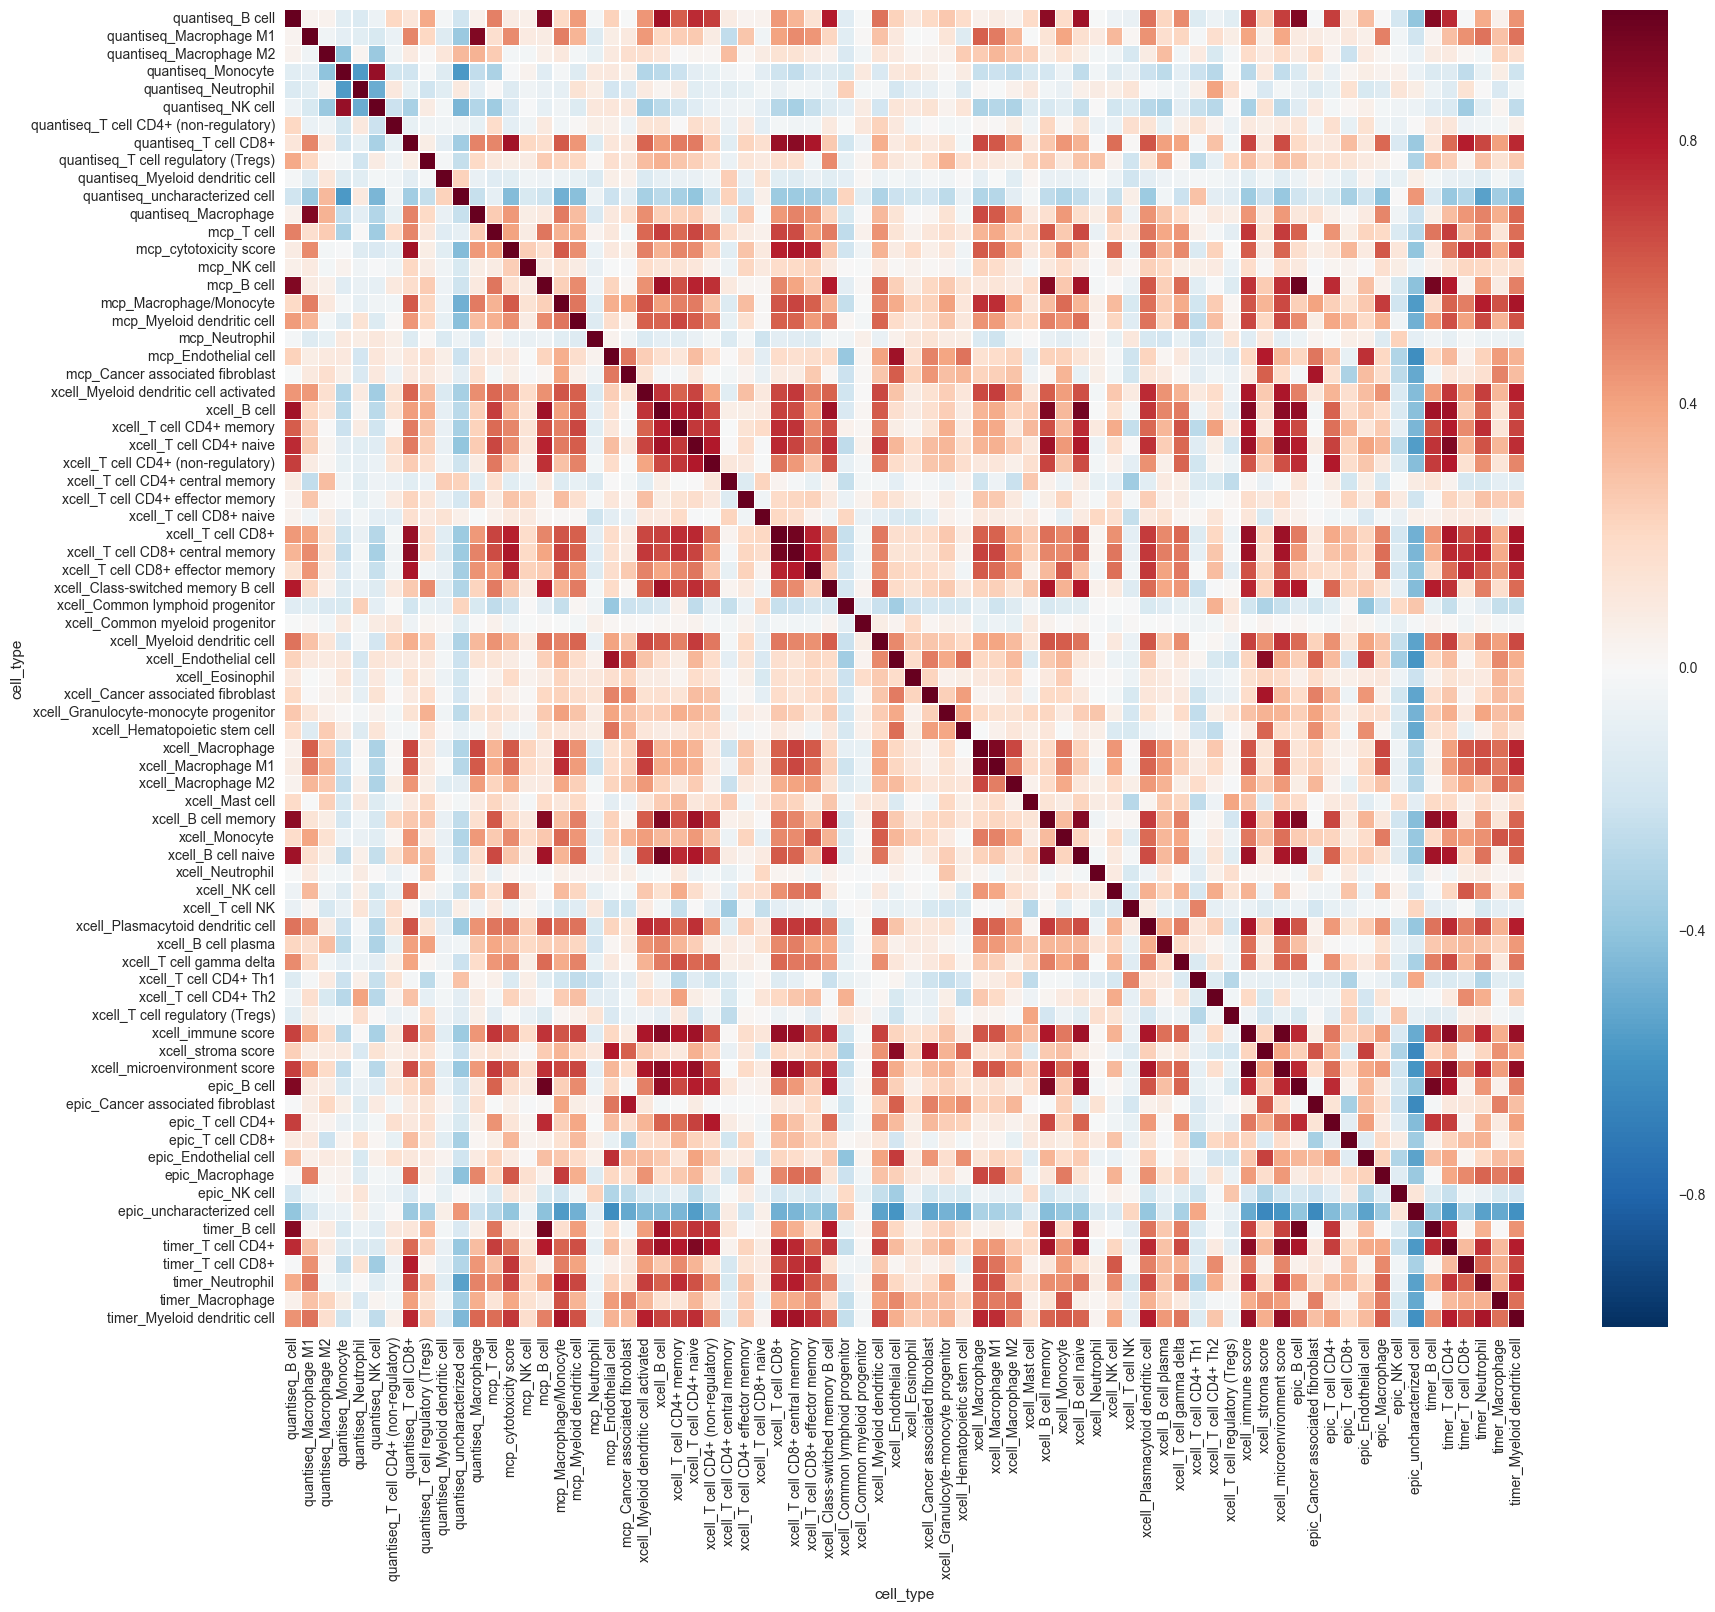

In [202]:
# correlation table is too big so heatmap will be used instead
plt.figure(figsize=(20, 17))
sns.heatmap(inf_cells.corr(), linewidths=.1)

Поскольку xcell вносил очень много информации в график, посмотрим отдельно на данные без него. Так становится более заметным корреляция результатов внутри mcp, а также очень сильное совпадение результатов для отдельных типов клеток между mcp и epic (например, Endothelial cell и Macrophage). Результаты quantiseq реже совпадают с этими алгоритмами, но все равно есть сильная корреляция для B клеток и макрофагов. При этом quantiseq в основном находит макрофаги 1 типа, что заметно по сильной корреляции нашей колонки Macrophage с M1 и значительно менее сильной корреляции М2. mcp cytotoxicity score сильно коррелирует с количеством СВ8+ (цитотоксических) Т лимфоцитов в quantiseq. Результаты всех алгоритмов хорошо совпадают для B клеток.

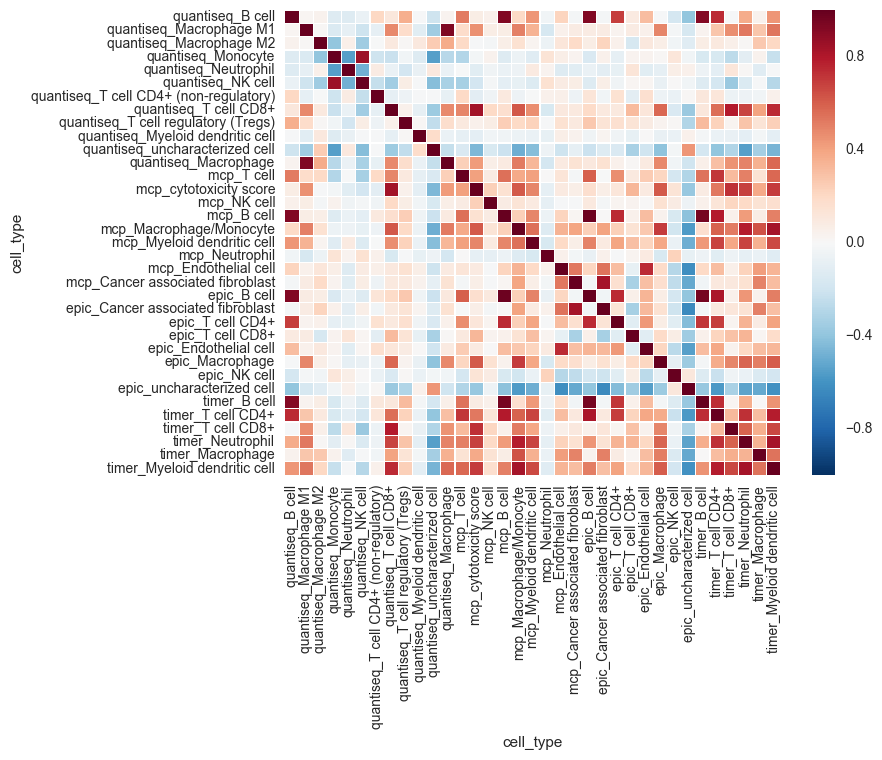

In [203]:
plt.figure(figsize=(8, 6))
sns.heatmap(quantiseq.join([mcp_counter, epic, timer]).corr(), linewidths=.1)

In [82]:
inf_cells.to_csv('./immunedeconv_matrixes.txt', sep='\t')

### 6. Предложить варианты кластеризации когорты больных меланомой по их клеточному составу. Привести использованные оценки качества кластеризации.
Большинство алгоритмов кластеризации требуют указать количество кластеров, которое требуется найти. Попробуем оценить порядок количества кластеров, которые требуется искать.

In [87]:
inf_cells = pd.read_csv('./immunedeconv_matrixes.txt', sep='\t', index_col=0)
inf_cells.head()

,quantiseq_B cell,quantiseq_Macrophage M1,quantiseq_Macrophage M2,quantiseq_Monocyte,quantiseq_Neutrophil,quantiseq_NK cell,quantiseq_T cell CD4+ (non-regulatory),quantiseq_T cell CD8+,quantiseq_T cell regulatory (Tregs),quantiseq_Myeloid dendritic cell,...,epic_Endothelial cell,epic_Macrophage,epic_NK cell,epic_uncharacterized cell,timer_B cell,timer_T cell CD4+,timer_T cell CD8+,timer_Neutrophil,timer_Macrophage,timer_Myeloid dendritic cell
TCGA-3N-A9WB,0.019010,0.025357,0.000000,0.132628,0.034339,0.027568,0.033914,0.000000,0.032508,0.0,...,0.014515,0.000652,0.014319,0.874098,0.063388,0.037520,0.063192,0.047289,0.0,0.248637
TCGA-3N-A9WC,0.018577,0.077029,0.022916,0.000000,0.596110,0.011411,0.000000,0.162333,0.015568,0.0,...,0.034526,0.009487,0.005034,0.588358,0.047614,0.332219,0.154635,0.265385,0.0,0.596707
TCGA-3N-A9WD,0.040618,0.048196,0.031013,0.075932,0.074128,0.026484,0.000000,0.043388,0.097349,0.0,...,0.046196,0.010601,0.001449,0.674729,0.130618,0.129352,0.108501,0.095524,0.0,0.395941
TCGA-BF-A1PU,0.005079,0.023847,0.000000,0.476890,0.000000,0.111910,0.000000,0.000000,0.035172,0.0,...,0.052852,0.004436,0.022689,0.702836,0.078863,0.000000,0.146578,0.054510,0.0,0.309826
TCGA-BF-A1PV,0.009409,0.000000,0.000000,0.194886,0.484746,0.079115,0.050163,0.000000,0.029180,0.0,...,0.020155,0.002031,0.039516,0.745956,0.052074,0.000000,0.135438,0.051900,0.0,0.287516


In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

К сожалению, визуальна на PCA не удается выделить какие-то выраженные кластеры.

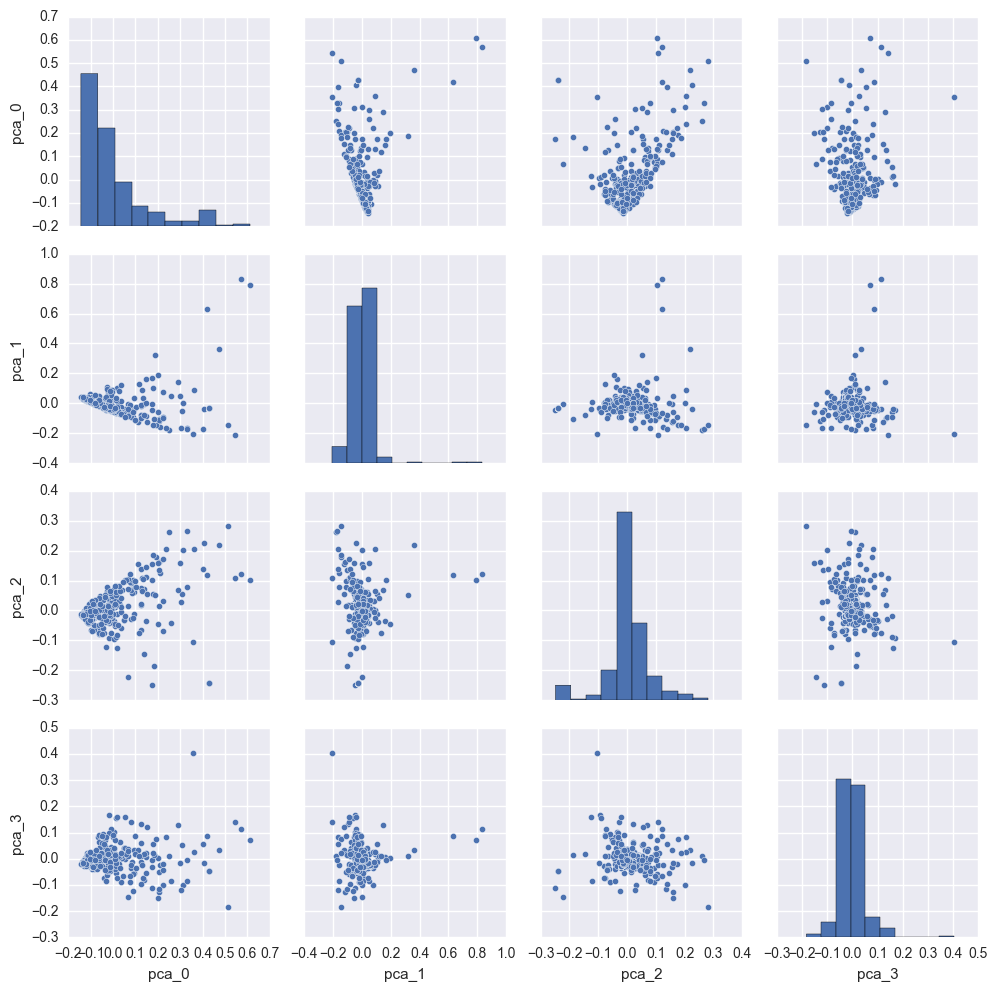

In [28]:
# PCA performs better on normalized features
inf_cells_scaled = preprocessing.Normalizer().fit_transform(inf_cells)

n = 4
pca = PCA(n_components=n)
inf_pca = pd.DataFrame(pca.fit_transform(inf_cells_scaled), columns=list(map((lambda x: 'pca_'+str(x)), range(n))))
sns.pairplot(inf_pca, vars=inf_pca.columns)

При использовании алгоритма TSNE выраженные кластеры также отсутствуют.

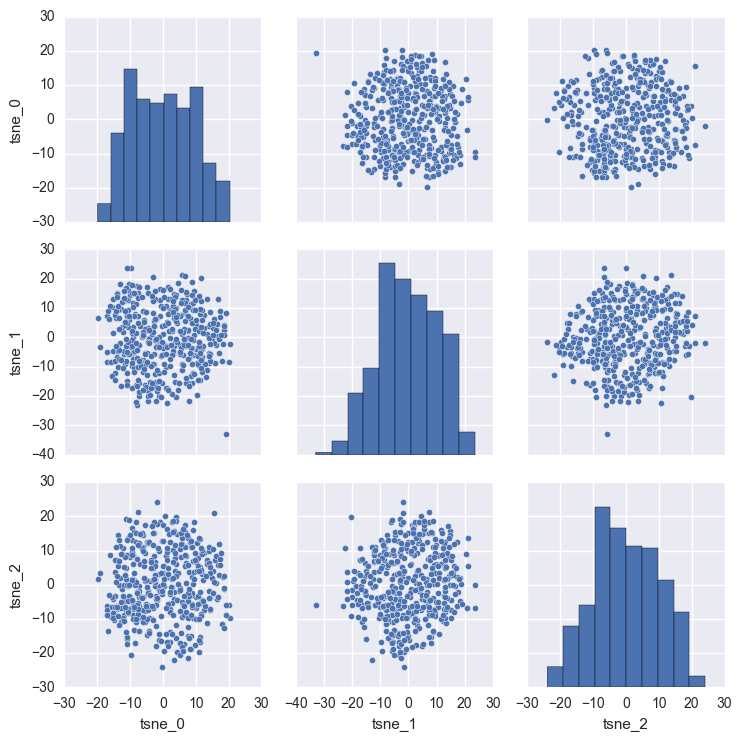

In [40]:
# TSNE is resistant to outliers and does not require normalization
n = 3
tsne = TSNE(n_components=n)
inf_tsne = pd.DataFrame(tsne.fit_transform(inf_cells), columns=list(map((lambda x: 'tsne_'+str(x)), range(n))))
sns.pairplot(inf_tsne, vars=inf_tsne.columns)

С подходом TSNE выраженные кластеры стали заметны заметны при использовании только двух компонент, на картинке мы можем наблюдать четыре кластера. TSNE является недетерминированным алгоритмом и потому результаты варьируют от запуска к запуску с количеством кластеров 3-5, либо со сложной зигзагообразной формой результата.

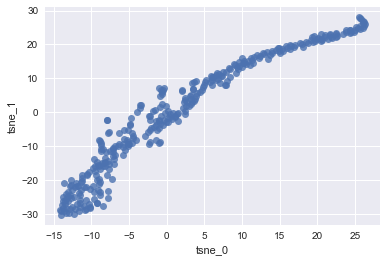

In [94]:
n = 2
tsne = TSNE(n_components=n)
inf_tsne = pd.DataFrame(tsne.fit_transform(inf_cells), 
                        columns=list(map((lambda x: 'tsne_'+str(x)), range(n))), 
                        index=inf_cells.index)
sns.regplot(inf_tsne.iloc[:,0], inf_tsne.iloc[:,1], fit_reg=False)

Попробуем применить модели кластеризации исходя из предположения, что в данных действительно около 4 выраженных кластеров.

In [14]:
from sklearn.mixture import GaussianMixture

In [95]:
# GMM is more adaptive compared to simple methods like kmeans since it can 
# find clusters with oval shapes and different densities
gmm = GaussianMixture(n_components=4)
gmm.fit(inf_tsne)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

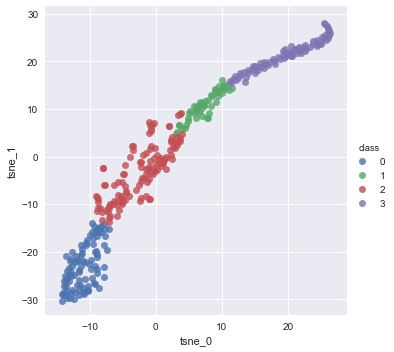

In [96]:
inf_tsne['class'] = gmm.predict(inf_tsne)
sns.lmplot('tsne_0', 'tsne_1', inf_tsne, hue='class', fit_reg=False)

### 7. Проанализировать, есть ли разница по выживаемости пациентов между найденными кластерами. Опишите возможную биологическую причину этой разницы?

Для начала посмотрим на разницу количества выживших пациентов для разных кластеров, найденный GMM на данных TSNE.

In [108]:
data_pat = pd.read_csv('./skcm_tcga/data_bcr_clinical_data_patient_filtered.txt', sep='\t', index_col=1)

На первый взгляд пациенты из класса под номером 2 чаще выживают по сравнению с остальными.

In [113]:
inf_tsne['OS_STATUS'] = data_pat['OS_STATUS']
inf_tsne.groupby(['class', 'OS_STATUS']).size()

class  OS_STATUS
0      DECEASED     39
       LIVING       55
1      DECEASED     21
       LIVING       28
2      DECEASED     42
       LIVING       75
3      DECEASED     37
       LIVING       39
dtype: int64

Проверим эту гипотезу тестом Фишера.

Тестом Фишера удалось обнаружить, что принадлежность второй группе повышает шанс на выживание пациента, а выживание пациента в 3 группе наоборот, существенно ниже среднего по выборке. Тем не менее p-value для этих утверджений все равно выше порога в 0.05, поэтому гипотезу о влиянии конкретного кластера на виживаемость пациентов не подтвердилась. Возможно, гипотеза может быть отвергнута на большей выборке пациентов.

In [135]:
import scipy.stats as stats

surv_groups = inf_tsne.groupby(['class', 'OS_STATUS']).size()
dec_all     = inf_tsne.groupby(['OS_STATUS']).size()['DECEASED']
liv_all     = inf_tsne.groupby(['OS_STATUS']).size()['LIVING']

for i in range(4):
    oddsratio, pvalue = stats.fisher_exact([[surv_groups[i, 'LIVING'], surv_groups[i, 'DECEASED']],
                                            [liv_all-surv_groups[i, 'LIVING'], dec_all-surv_groups[i, 'DECEASED']]])
    print('class %d: odds ratio = %.3f, pvalue = %.3f'%(i, oddsratio, pvalue))

class 0: odds ratio = 0.993, pvalue = 1.000
class 1: odds ratio = 0.931, pvalue = 0.876
class 2: odds ratio = 1.420, pvalue = 0.163
class 3: odds ratio = 0.680, pvalue = 0.148


### 8. (опционально) С помощью данных по соматическим мутациям (также доступны для этой когорты на cBioPortal) в онкогенах и онкосуппресорах оцените наличие ассоциации между генетическими особенностями образцов опухолей и их типами по клеточному составу.